# Resultados

Aqui vamos comparar os resultados obtidos com os métodos de segmentação semi-automático e automático com o segmentação do BrainGPS através da métrica IoU.

In [57]:
# Importando pacotes

import os
import nibabel as nib
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
import skimage.filters as skf
from skimage.segmentation import watershed
from skimage.morphology import remove_small_holes, remove_small_objects
import pandas as pd

In [38]:
# Definindo funções e variáveis para carregar imagens


def loadImagesFromName(dir_name, name):
    fname_s = dir_name+name+'/'+name+'_287Labels_M2.hdr'
    fname = dir_name+name+'/'+name+'.hdr'
    sf = nib.load(fname_s).get_fdata()
    f = nib.load(fname).get_fdata()
    
    sx = int(sf.shape[0]/2)
    simg = ndi.rotate(sf[sx,:,:], 90)
    simg = simg[:,:,0].astype(np.uint8)
    
    x = int(f.shape[0]/2)
    img = ndi.rotate(f[x,:,:], 90)
    img = 255*img/np.max(img)
    img = img[:,:,0].astype(np.uint8)
    
    return img, simg

gps_dir_name = "../data/segmented_braingps/"
file_names = os.listdir(gps_dir_name)
file_names.sort()
file_names = file_names[:-1]

In [47]:
# Definindo o método de segmentação semi-automático

def SemiAutomaticWatershed(img, plot=False):
    target_pixel = {"v": 0, "x": 0, "y": 0}
    
    n_mean = 5
    mean_filter = 1/(n_mean**2)*np.ones((n_mean, n_mean))
    mean_img = skf.edges.convolve(img, mean_filter)
    
    def getPixelValue(event, x, y, flags, param, tp):
        if event == cv.EVENT_LBUTTONDOWN:
            tp["v"] = mean_img[y,x]
            tp["x"] = x
            tp["y"] = y
    cv.namedWindow("SelectCC", cv.WINDOW_AUTOSIZE)
    cv.setMouseCallback("SelectCC", lambda event, x, y, flags, param: getPixelValue(event, x, y, flags, param, target_pixel))
    while (True):
        cv.imshow('SelectCC', img)
        if cv.waitKey(1) == ord('q'):
            break

        if cv.getWindowProperty('SelectCC',cv.WND_PROP_VISIBLE) < 1:        
            break      

    cv.destroyAllWindows()
    
    # Watershed
    threshold_img = np.ones(img.shape, np.int8)
    lower_limit, upper_limit = max(target_pixel['v']-20, 0), min(target_pixel['v']+20, 255)
    threshold_img[img < lower_limit] = 0
    threshold_img[img > upper_limit] = 0

    distance = ndi.distance_transform_edt(threshold_img)

    markers = np.zeros(distance.shape, dtype=bool) 
    markers = (distance==0)*1
    markers[target_pixel['y'],target_pixel['x']] = 2

    labels = watershed(-distance, markers)


    # Removendo objetos pequenos e buracos
    final = remove_small_holes(labels-1, 64)

    # Plot
    if plot:
        fig, axes = plt.subplots(ncols=5, figsize=(9, 3), sharex=True, sharey=True)
        ax = axes.ravel()

        ax[0].imshow(img, cmap=plt.cm.gray)
        ax[0].set_title('Original')
        ax[1].imshow(threshold_img, cmap=plt.cm.gray)
        ax[1].set_title('Threshold')
        ax[2].imshow(distance, cmap=plt.cm.gray)
        ax[2].set_title('Distance')
        ax[3].imshow(labels, cmap=plt.cm.nipy_spectral)
        ax[3].set_title('Watershed')
        ax[4].imshow(final, cmap=plt.cm.gray)
        ax[4].set_title('Final')

        for a in ax:
            a.set_axis_off()

        fig.tight_layout()
        plt.show()
    
    return final

In [48]:
# Definindo o método de segmentação automático

def AutomaticWatershed(img, plot=False):
    
    def getBrainstemPosition(f):
        height, width = f.shape
        x_min, x_max = width//2-40, width//2+20
        y_min, y_max = height//3, 9*height//10
        brainstem = f[y_min:y_max, x_min:x_max]

        sub_height, sub_width = brainstem.shape

        h_x, h_y = 11, sub_height//2
        h_filter = (1/(h_y*h_x))*(np.ones((h_y,h_x)))

        mean_img = skf.edges.convolve(brainstem, h_filter, mode="wrap")

        mean_img_id_max = np.argmax(mean_img)

        brainstem_y = mean_img_id_max//sub_width + y_min
        brainstem_x = mean_img_id_max%sub_width + x_min

        return brainstem_x, brainstem_y
    
    def getSubImgFromBrainstem(img, brainstem):
        height, width = img.shape
        center_y = height//2
        center_x = width//2 
        brainstem_size = np.sum(brainstem)
        if 25<brainstem_size<2000:
            reference_y = 0
            for i in range(height):
                if np.sum(brainstem[i,:]) > 0:
                    reference_y = i
                    break

            min_y, max_y = reference_y-50, reference_y-10
            min_x, max_x = center_x-50, center_x+50
        else:
            min_y, max_y = 75, center_y
            min_x, max_x = center_x-50, center_x+50

        return img[min_y:max_y, min_x:max_x], min_x, min_y
    
    def getCCPositionFromSubImg(f, x_min, y_min):
        height, width = f.shape    
        n_mean=11
        mean_img = skf.median(f, np.ones((n_mean,n_mean))/n_mean**2)
        mean_img_id_max = np.argmax(mean_img)

        cc_y = mean_img_id_max//width
        cc_x = mean_img_id_max%width

        return cc_x+x_min, cc_y+y_min
    
    def watershedFromPoint(img, target_x, target_y, threshold_width, plot=False):
        n_mean = 5
        mean_filter = 1/(n_mean**2)*np.ones((n_mean, n_mean))
        mean_img = skf.edges.convolve(img, mean_filter)

        target_value = mean_img[target_y, target_x]

        threshold_img = np.ones(img.shape, np.int8)
        lower_limit, upper_limit = max(target_value-threshold_width, 0), min(target_value+threshold_width, 255)
        threshold_img[img < lower_limit] = 0
        threshold_img[img > upper_limit] = 0

        distance = ndi.distance_transform_edt(threshold_img)

        markers = np.zeros(distance.shape, dtype=bool) 
        markers = (distance==0)*1
        markers[target_y, target_x] = 2

        labels = watershed(-distance, markers)

        # Removendo objetos pequenos e buracos
        final = remove_small_holes(labels-1, 64)
        
        # Plot
        if plot:
            fig, axes = plt.subplots(ncols=5, figsize=(9, 3), sharex=True, sharey=True)
            ax = axes.ravel()

            ax[0].imshow(img, cmap=plt.cm.gray)
            ax[0].set_title('Original')
            ax[1].imshow(threshold_img, cmap=plt.cm.gray)
            ax[1].set_title('Threshold')
            ax[2].imshow(distance, cmap=plt.cm.gray)
            ax[2].set_title('Distance')
            ax[3].imshow(labels, cmap=plt.cm.nipy_spectral)
            ax[3].set_title('Watershed')
            ax[4].imshow(final, cmap=plt.cm.gray)
            ax[4].set_title('Final')

            for a in ax:
                a.set_axis_off()

            fig.tight_layout()
            plt.show()
        return final
    
    height, width = img.shape
    threshold_sensitivity = 20

    brainstem_x, brainstem_y = getBrainstemPosition(img)
    brainstem = watershedFromPoint(img, brainstem_x, brainstem_y, threshold_sensitivity)

    sub_img, min_x, min_y = getSubImgFromBrainstem(img, brainstem)

    cc_x, cc_y = getCCPositionFromSubImg(sub_img, min_x, min_y)
    cc = watershedFromPoint(img, cc_x, cc_y, threshold_sensitivity)
    
    return cc

/usr/local/lib/python3.8/dist-packages/skimage/_shared/utils.py:157: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  return func(*args, **kwargs)


CC0005_philips_15_62_M 
Semi-Automatic IoU:0.8553092182030338 
Automatic IoU:0.8707093821510298


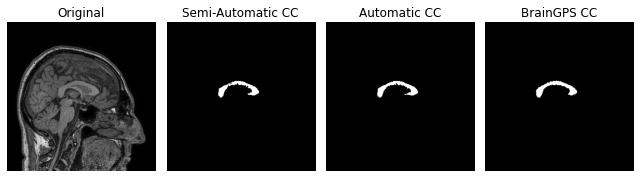

CC0044_philips_15_36_M 
Semi-Automatic IoU:0.8236889692585895 
Automatic IoU:0.8240495137046862


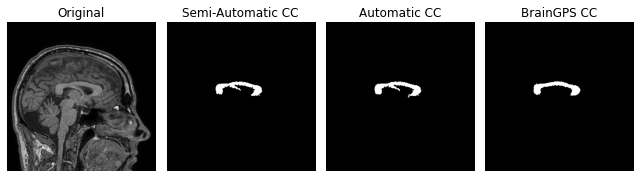

CC0074_philips_3_53_F 
Semi-Automatic IoU:0.8643790849673203 
Automatic IoU:0.8771331058020477


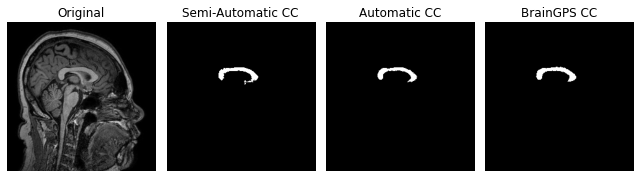

CC0114_philips_3_60_M 
Semi-Automatic IoU:0.8865497076023392 
Automatic IoU:0.8650234741784038


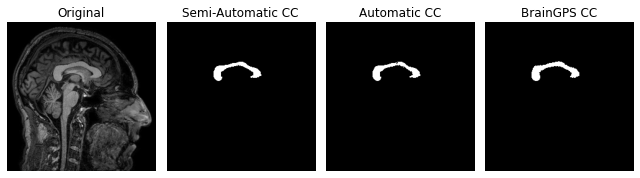

CC0141_siemens_15_53_F 
Semi-Automatic IoU:0.8779174147217235 
Automatic IoU:0.8600746268656716


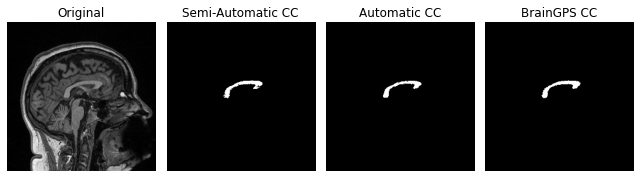

CC0144_siemens_15_43_M 
Semi-Automatic IoU:0.8629173989455184 
Automatic IoU:0.8811188811188811


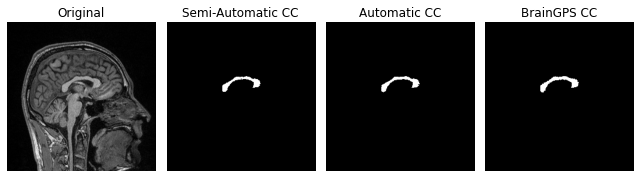

CC0232_siemens_3_56_M 
Semi-Automatic IoU:0.7258536585365853 
Automatic IoU:0.7202323330106486


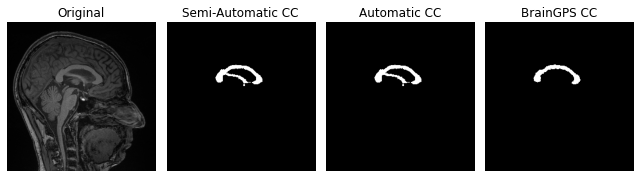

CC0238_siemens_3_58_M 
Semi-Automatic IoU:0.3232758620689655 
Automatic IoU:0.4594953519256308


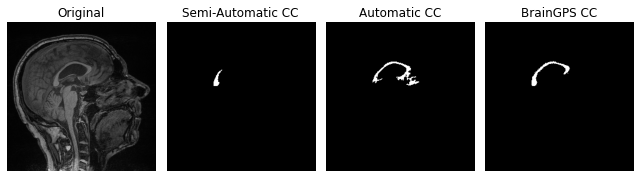

CC0263_ge_15_51_M 
Semi-Automatic IoU:0.8619186046511628 
Automatic IoU:0.8619186046511628


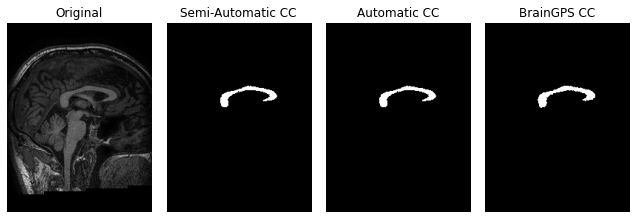

CC0281_ge_15_56_M 
Semi-Automatic IoU:0.8754325259515571 
Automatic IoU:0.8606271777003485


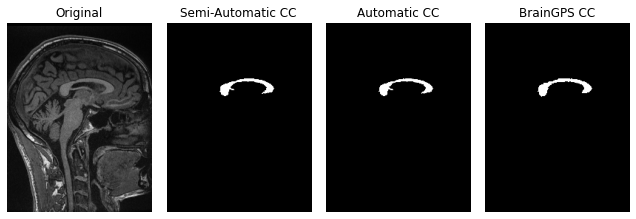

CC0318_ge_3_52_F 
Semi-Automatic IoU:0.8747993579454254 
Automatic IoU:0.8638573743922204


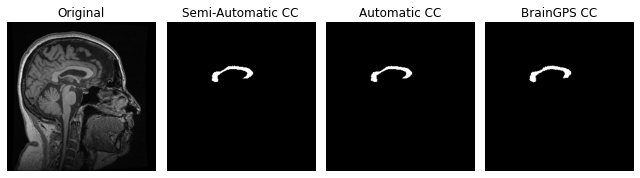

CC0338_ge_3_51_M 
Semi-Automatic IoU:0.2821959979476655 
Automatic IoU:0.8097412480974124


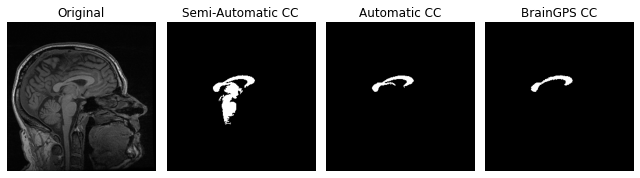

In [60]:
# Calculando o IoU e exibindo os resultados
def IoU(f,g):
    I = np.sum((f+g)==2)
    U = np.sum((f+g)>=1)
    return I/U

IoU_data = []
for name in file_names:
    img, simg = loadImagesFromName(gps_dir_name, name)
    
    brainGPS_cc = ((simg>120)*1+(simg<140)*1==2)*1
    auto_cc = AutomaticWatershed(img) 
    semiauto_cc = SemiAutomaticWatershed(img)
    
    autoIoU = IoU(brainGPS_cc, auto_cc)
    semiautoIoU = IoU(brainGPS_cc, semiauto_cc)
    
    print(name, "\nSemi-Automatic IoU:"+str(semiautoIoU), "\nAutomatic IoU:"+str(autoIoU))
    IoU_data.append([name,semiautoIoU,autoIoU])
    
    # Plot    
    color_1, color_2 = np.array([0,0,255]), np.array([255,255,0])
    fused = my_cc[..., np.newaxis] *color_1.reshape((1,1,-1))
    fused += gps_cc[..., np.newaxis] *color_2.reshape((1,1,-1))
    
    fig, axes = plt.subplots(ncols=4, figsize=(9, 3), sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(img, cmap=plt.cm.gray)
    ax[0].set_title('Original')
    ax[1].imshow(semiauto_cc, cmap=plt.cm.gray)
    ax[1].set_title('Semi-Automatic CC')
    ax[2].imshow(auto_cc, cmap=plt.cm.gray)
    ax[2].set_title('Automatic CC')
    ax[3].imshow(brainGPS_cc, cmap=plt.cm.gray)
    ax[3].set_title("BrainGPS CC")

    for a in ax:
        a.set_axis_off()

    fig.tight_layout()
    plt.show()
    
df_IoU_data = pd.DataFrame(IoU_data, columns=['img_name', 'Semi-Automatic IoU', 'Automatic IoU'])
df_IoU_data.to_csv("../data/IoU.csv", index=False)